# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

# Log-Likelihood Test 

In [2]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

# Reading the Dataset

### Full Dataset

In [3]:
data = pd.read_csv('web_scrapped_data.csv')
data = data.drop([0], axis=0)
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')

data.head()

,spx,dax,ftse,nikkei,spx_norm,dax_norm,ftse_norm,nikkei_norm,spx_ret,ftse_ret,dax_ret,nikkei_ret,spx_ret_norm,ftse_ret_norm,dax_ret_norm,nikkei_ret_norm,spx_vol,dax_vol,ftse_vol,nikkei_vol
Date,,,,,,,,,,,,,,,,,,,,
1994-01-06,467.119995,2220.629883,3403.000000,18124.009766,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,2224.949951,3446.000000,18124.009766,100.595136,100.194542,101.263591,100.000000,0.595136,1.263591,0.194542,-2.069078e-09,100.000000,100.000000,100.000000,1.000000e+02,0.354187,0.037847,1.596662,4.281085e-18
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,101.744732,100.196796,101.104910,101.762467,1.142795,-0.156701,0.002249,1.762467e+00,192.022581,-12.401212,1.156270,-8.518126e+10,1.305981,0.000005,0.024555,3.106290e+00
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,101.500687,100.336401,100.317368,101.993158,-0.239860,-0.778935,0.139330,2.266960e-01,-40.303454,-61.644578,71.619440,-1.095638e+10,0.057533,0.019413,0.606740,5.139109e-02
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,101.509252,98.263113,99.089039,103.696042,0.008438,-1.224443,-2.066336,1.669606e+00,1.417879,-96.901880,-1062.151695,-8.069323e+10,0.000071,4.269745,1.499262,2.787584e+00


### Traininig Data

In [4]:
train_df = pd.read_csv('train.csv')
train_df = train_df.drop([0], axis=0)
train_df.Date = pd.to_datetime(train_df.Date)
train_df = train_df.set_index('Date')

train_df.head()

,spx,dax,ftse,nikkei,spx_norm,dax_norm,ftse_norm,nikkei_norm,spx_ret,ftse_ret,dax_ret,nikkei_ret,spx_ret_norm,ftse_ret_norm,dax_ret_norm,nikkei_ret_norm,spx_vol,dax_vol,ftse_vol,nikkei_vol
Date,,,,,,,,,,,,,,,,,,,,
1994-01-06,467.119995,2220.629883,3403.000000,18124.009766,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,2224.949951,3446.000000,18124.009766,100.595136,100.194542,101.263591,100.000000,0.595136,1.263591,0.194542,-2.069078e-09,100.000000,100.000000,100.000000,1.000000e+02,0.354187,0.037847,1.596662,4.281085e-18
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,101.744732,100.196796,101.104910,101.762467,1.142795,-0.156701,0.002249,1.762467e+00,192.022581,-12.401212,1.156270,-8.518126e+10,1.305981,0.000005,0.024555,3.106290e+00
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,101.500687,100.336401,100.317368,101.993158,-0.239860,-0.778935,0.139330,2.266960e-01,-40.303454,-61.644578,71.619440,-1.095638e+10,0.057533,0.019413,0.606740,5.139109e-02
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,101.509252,98.263113,99.089039,103.696042,0.008438,-1.224443,-2.066336,1.669606e+00,1.417879,-96.901880,-1062.151695,-8.069323e+10,0.000071,4.269745,1.499262,2.787584e+00


### Testing Data

In [5]:
test_df = pd.read_csv('test.csv')
test_df = test_df.drop([0], axis=0)
test_df.Date = pd.to_datetime(test_df.Date)
test_df = test_df.set_index('Date')

test_df.head()

,spx,dax,ftse,nikkei,spx_norm,dax_norm,ftse_norm,nikkei_norm,spx_ret,ftse_ret,dax_ret,nikkei_ret,spx_ret_norm,ftse_ret_norm,dax_ret_norm,nikkei_ret_norm,spx_vol,dax_vol,ftse_vol,nikkei_vol
Date,,,,,,,,,,,,,,,,,,,,
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,422.435359,437.687083,197.193653,84.943455,-0.193210,-0.527714,-0.650103,0.642878,-32.464781,-41.763021,-334.170049,-3.107073e+10,0.037330,0.422634,0.278482,0.413292
2014-07-16,1981.569946,9859.269531,6784.700195,15379.299805,424.210046,443.985268,199.374087,84.855945,0.420108,1.105733,1.438970,-0.103022,70.590347,87.507175,739.668688,4.979110e+09,0.176491,2.070634,1.222645,0.010613
2014-07-17,1958.119995,9753.879883,6738.299805,15370.259766,419.189933,439.239333,198.010573,84.806066,-1.183403,-0.683897,-1.068940,-0.058781,-198.845784,-54.123325,-549.463410,2.840906e+09,1.400442,1.142632,0.467716,0.003455
2014-07-18,1978.219971,9720.019531,6749.500000,15215.709961,423.492891,437.714524,198.339700,83.953331,1.026494,0.166217,-0.347148,-1.005512,172.480531,13.154331,-178.443043,4.859710e+10,1.053689,0.120511,0.027628,1.011054
2014-07-21,1973.630005,9612.049805,6728.399902,15215.709961,422.510281,432.852403,197.719656,83.953331,-0.232025,-0.312617,-1.110797,0.000000,-38.986902,-24.740380,-570.979380,-0.000000e+00,0.053836,1.233871,0.097730,0.000000


# ACF and PACF Plot Function

In [6]:
def acf_pacf(series, label_str):
    plt.rcParams['figure.figsize'] = 20, 5
    fig, (ax0, ax1) = plt.subplots(1, 2)

    sgt.plot_acf(series, zero = False, lags = 40, ax=ax0)
    ax0.set_title("ACF for "+label_str, size = 20)

    sgt.plot_pacf(series, zero = False, lags = 40, ax=ax1)
    ax1.set_title("PACF for "+label_str, size = 20)

    plt.show()

# SARIMAX For SPX Prices

#### ACF and PACF Plots for SPX Prices

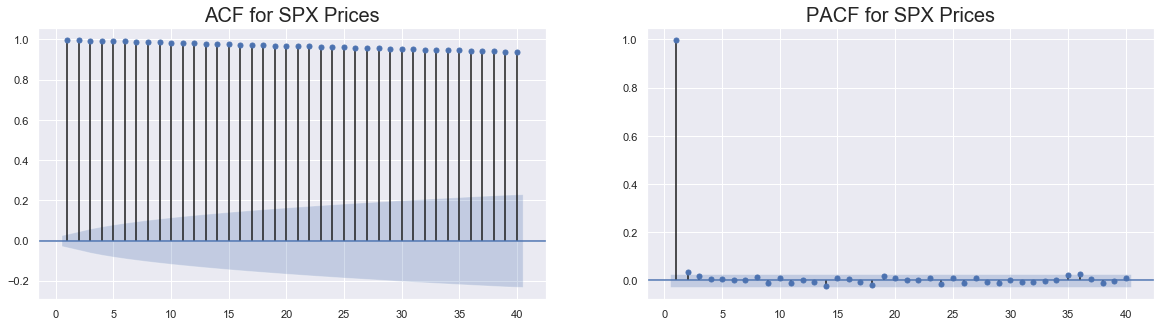

In [7]:
acf_pacf(train_df.spx, "SPX Prices")

#### Function to fit and plot SARIMAX Models

In [8]:
def fit_sarima_model(train_data, model_name, p, d, q, P, D, Q, M, exog_data=None):
    sarima_model = SARIMAX(train_data, exog=exog_data, order=(p, d, q), seasonal_order = (P, D, Q, M))
    sarima_model_results = sarima_model.fit()
    print("SARIMA(%d, %d, %d)(%d, %d, %d, %d) Model" %(p, d, q, P, D, Q, M))
    print(sarima_model_results.summary())
    acf_pacf(sarima_model_results.resid, model_name)
    
    print("-------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------")
    
    return sarima_model_results

# SARIMAX For SPX Prices

#### Fitting SARIMAX(1, 1, 1)(2, 0, 1, 5)

SARIMA(1, 1, 1)(2, 0, 1, 5) Model
                                 Statespace Model Results                                
Dep. Variable:                               spx   No. Observations:                 5353
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 5)   Log Likelihood              -20342.460
Date:                           Sun, 14 Jun 2020   AIC                          40698.919
Time:                                   17:38:31   BIC                          40745.016
Sample:                               01-06-1994   HQIC                         40715.020
                                    - 07-14-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ftse           0.1338      0.002     81.118      0.000       0.131       0.137
ar.L1    

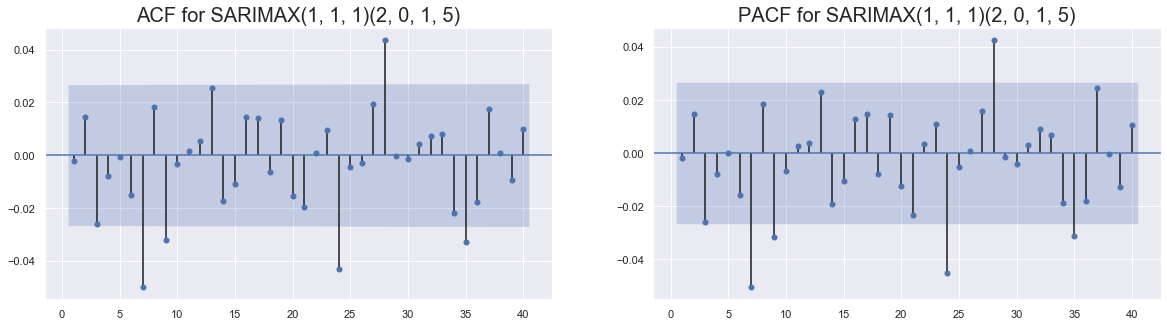

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------


In [9]:
sarima_model_results = fit_sarima_model(train_df.spx, "SARIMAX(1, 1, 1)(2, 0, 1, 5)", 1, 1, 1, 2, 0, 1, 5, train_df.ftse)

#### Predictions using SARIMAX(1, 0, 1)(1, 0, 1, 5)

In [10]:
start_date, end_date = test_df.index[0], test_df.index[-1]

In [11]:
pred_df = sarima_model_results.predict(start=start_date, end=end_date, exog=test_df[['ftse']])

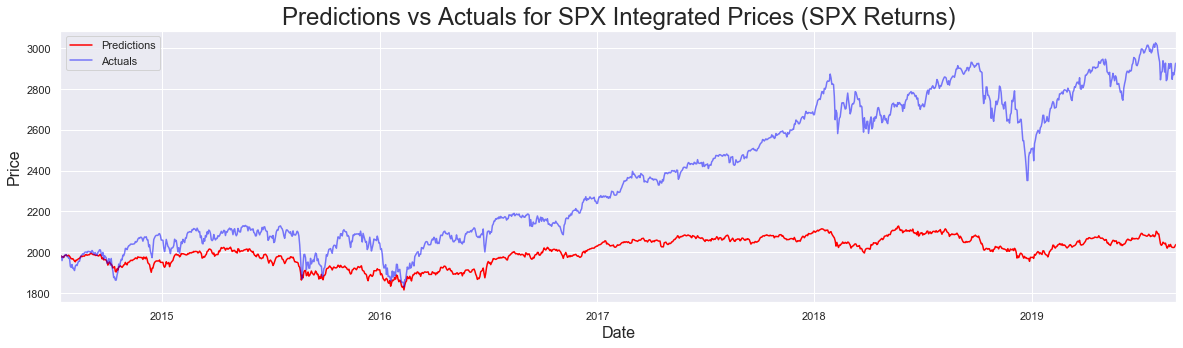

In [12]:
pred_df[start_date:end_date].plot(figsize = (20,5), color = "red", label='Predictions')
test_df.spx[start_date:end_date].plot(color = "blue", label='Actuals', alpha=0.5)

plt.title("Predictions vs Actuals for SPX Integrated Prices (SPX Returns)", size = 24)
plt.xlabel('Date', size=16)
plt.ylabel('Price', size=16)

plt.legend()
plt.show()

#### ACF and PACF Plots for SPX Returns

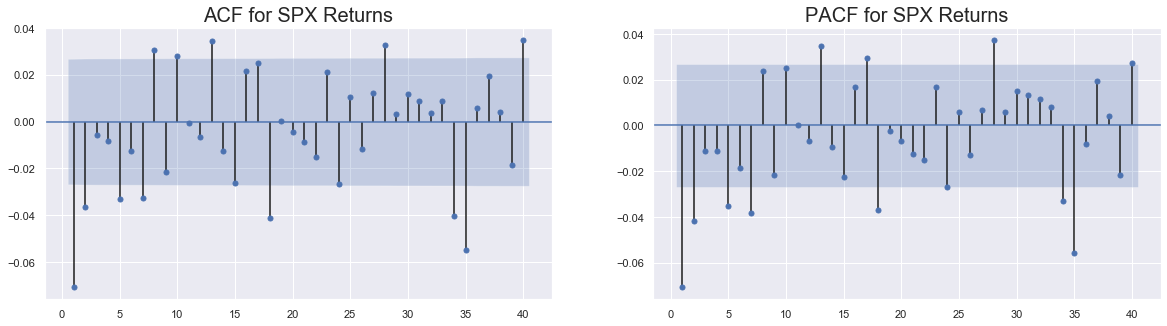

In [13]:
acf_pacf(train_df.spx_ret[1:], "SPX Returns")

#### Fitting SARIMAX(1, 1, 1)(2, 0, 1, 5)

SARIMA(1, 0, 1)(1, 0, 1, 5) Model
                                 Statespace Model Results                                
Dep. Variable:                           spx_ret   No. Observations:                 5352
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood               -7445.423
Date:                           Sun, 14 Jun 2020   AIC                          14902.846
Time:                                   17:38:37   BIC                          14942.357
Sample:                               01-07-1994   HQIC                         14916.646
                                    - 07-14-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ftse_ret       0.6157      0.007     87.589      0.000       0.602       0.629
ar.L1    

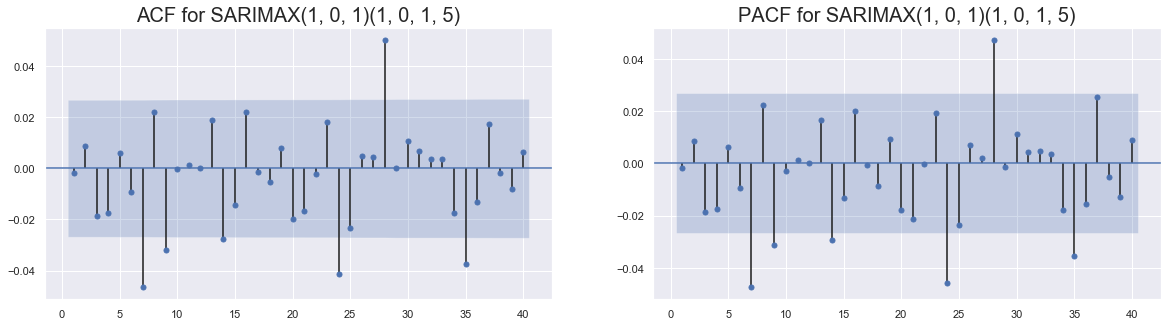

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------


In [14]:
ret_sarima_model_results = fit_sarima_model(train_df.spx_ret[1:], "SARIMAX(1, 0, 1)(1, 0, 1, 5)", 1, 0, 1, 1, 0, 1, 5, train_df.ftse_ret[1:])

#### Predictions using SARIMAX(1, 1, 1)(1, 0, 1, 5)

In [15]:
start_date, end_date = test_df.index[0], test_df.index[-1]

In [16]:
pred_df_ret = ret_sarima_model_results.predict(start=start_date, end=end_date, exog=test_df[['ftse_ret']])

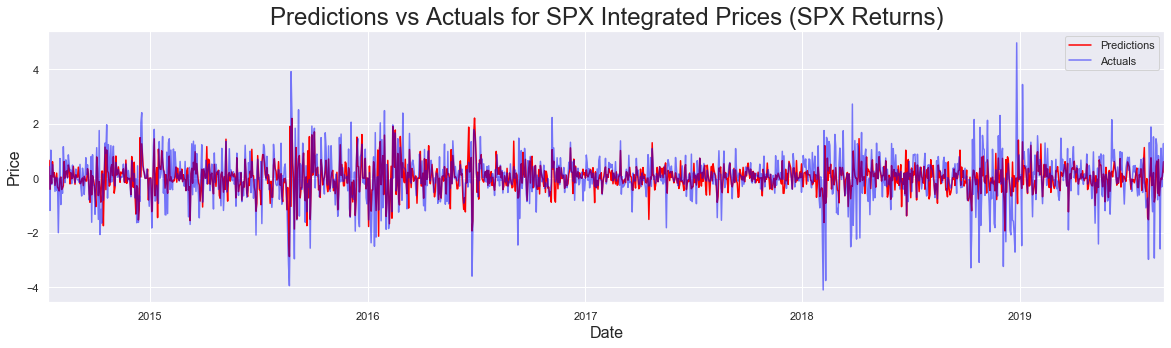

In [17]:
pred_df_ret[start_date:end_date].plot(figsize = (20,5), color = "red", label='Predictions')
test_df.spx_ret[start_date:end_date].plot(color = "blue", label='Actuals', alpha=0.5)

plt.title("Predictions vs Actuals for SPX Integrated Prices (SPX Returns)", size = 24)
plt.xlabel('Date', size=16)
plt.ylabel('Price', size=16)

plt.legend()
plt.show()

# Comparing Prediction Accuracies

In [18]:
start, end = test_df.index[0], test_df.index[-1]

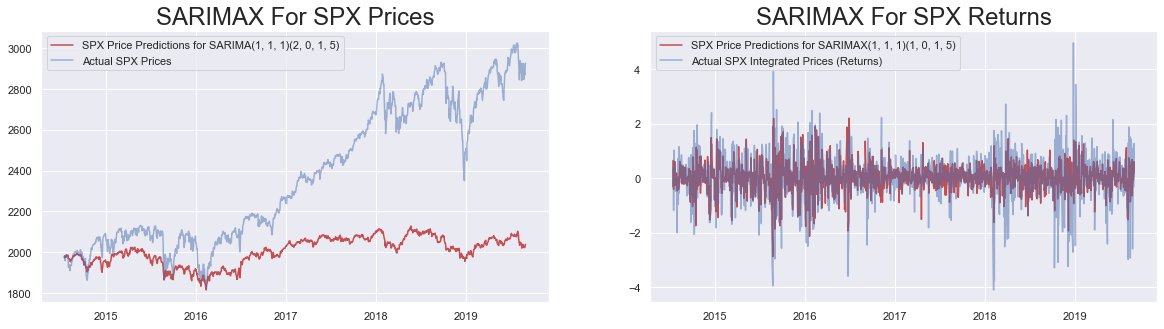

In [19]:
plt.rcParams['figure.figsize'] = 20, 5

fig, ax = plt.subplots(1, 2)

ax[0].plot(pred_df[start:end], color='r', label='SPX Price Predictions for SARIMA(1, 1, 1)(2, 0, 1, 5)')
ax[0].plot(test_df.spx[start:end], color='b', label='Actual SPX Prices', alpha=0.5)
ax[0].set_title('SARIMAX For SPX Prices', size=24)
ax[0].legend()

ax[1].plot(pred_df_ret[start:end], color='r', label='SPX Price Predictions for SARIMAX(1, 1, 1)(1, 0, 1, 5)')
ax[1].plot(test_df.spx_ret[start:end], color='b', label='Actual SPX Integrated Prices (Returns)', alpha=0.5)
ax[1].set_title('SARIMAX For SPX Returns', size=24)
ax[1].legend()

plt.show()

#### RMSE: SARIMAX(1, 1, 1)(2, 0 , 1, 5) on SPX Prices

In [20]:
mse = mean_squared_error(test_df.spx.values, pred_df.values)
rmse = sqrt(mse)

print("Root Mean Squared Error: "+str(rmse))

Root Mean Squared Error: 464.0125954564434


#### RMSE: SARIMAX(1, 1, 1)(1, 0 , 1, 5) on SPX Returns

In [21]:
mse = mean_squared_error(test_df.spx_ret.values, pred_df_ret.values)
rmse = sqrt(mse)

print("Root Mean Squared Error: "+str(rmse))

Root Mean Squared Error: 0.7314335739403373
